# Reverse time migration example on a 2D  acoustic model

## Set up environment.

In [1]:
from ipyparallel import Client
c = Client(profile='mpi')
dview = c[:]

with dview.sync_imports():
    import sys
    import numpy
    from examples.acoustic import demo_toolkit
    from examples.acoustic.Acoustic_codegen import Acoustic_cg
    from examples.containers import IGrid
    import os
    os.environ["DEVITO_OPENMP"] = "1"

# Setup figure size
%matplotlib inline

import matplotlib.pyplot as plt
fig_size = [0, 0]
fig_size[0] = 18
fig_size[1] = 13
plt.rcParams["figure.figsize"] = fig_size

importing sys on engine(s)
importing numpy on engine(s)
importing demo_toolkit from examples.acoustic on engine(s)
importing Acoustic_cg from examples.acoustic.Acoustic_codegen on engine(s)
importing IGrid from examples.containers on engine(s)
importing os on engine(s)


## Load synthetic velocity model.

tn is 1837.132616


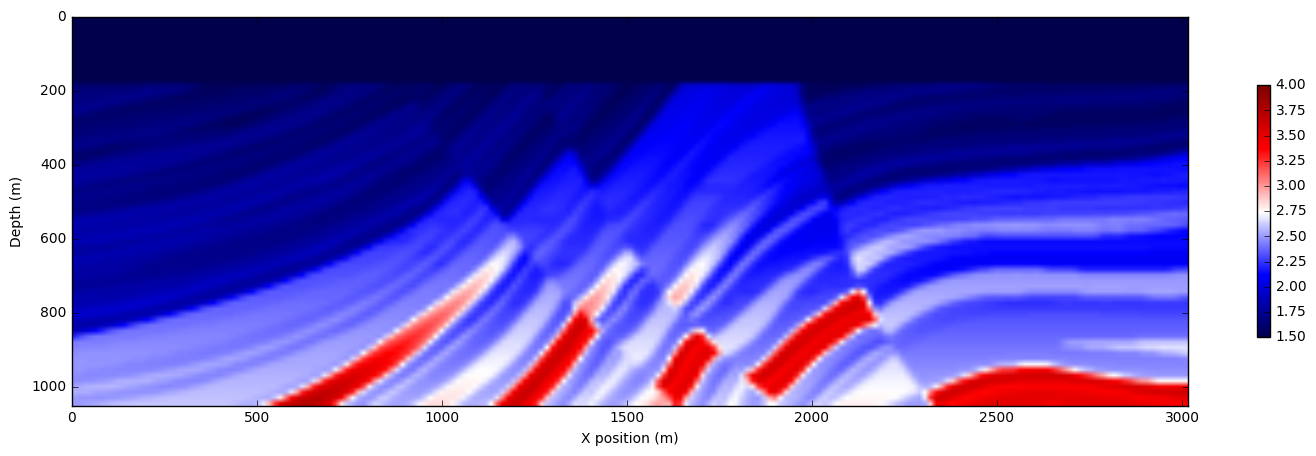

In [2]:
demo = demo_toolkit.small_marmousi2D()
model = demo.get_true_model()

demo.plot_velocity(model.vp)

## Create "initial guess" by smoothening the synthetic velocity model.

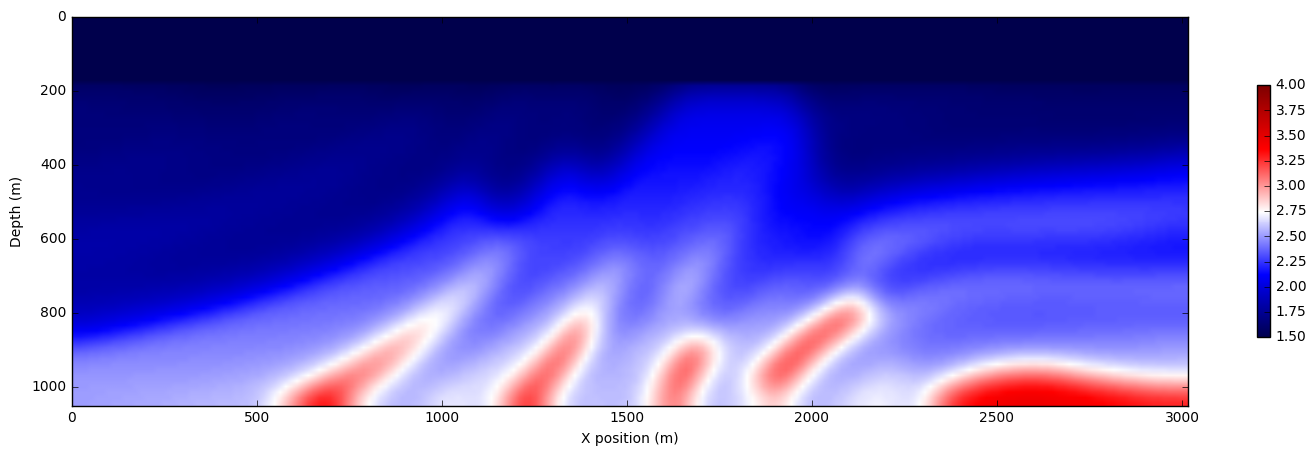

In [3]:
model0 = demo.get_initial_model()
demo.plot_velocity(model0.vp)

## Example of a shot record

In [4]:
# %load_ext snakeviz

/home/ggorman/projects/devito/examples/acoustic/demo_toolkit.py:230: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  location[0, 0] = self.sources[i]
Rewriter: 34 --> 28 flops (Gain: 1.21 X)
CustomCompiler: Compiling /tmp/devito-55029/6144b5c3fb3a39c42553652f85642114979556ba.c
Shape: (281 x 150) - Cache Blocking: None
Time: 0.554729 s (76 MCells/s)
Stencil: 1.625000 OI, 2.18 GFlops/s (time: 0.551117 s)
Rewriter: 62 --> 47 flops (Gain: 1.32 X)
CustomCompiler: Compiling /tmp/devito-55029/7794dfcb2414cad0abfaf5787eb4051d6c18a32d.c
Shape: (281 x 150) - Cache Blocking: None
Time: 0.853226 s (43 MCells/s)
Stencil: 2.937500 OI, 2.56 GFlops/s (time: 0.849412 s)


3.88758544922
(1096, 101)


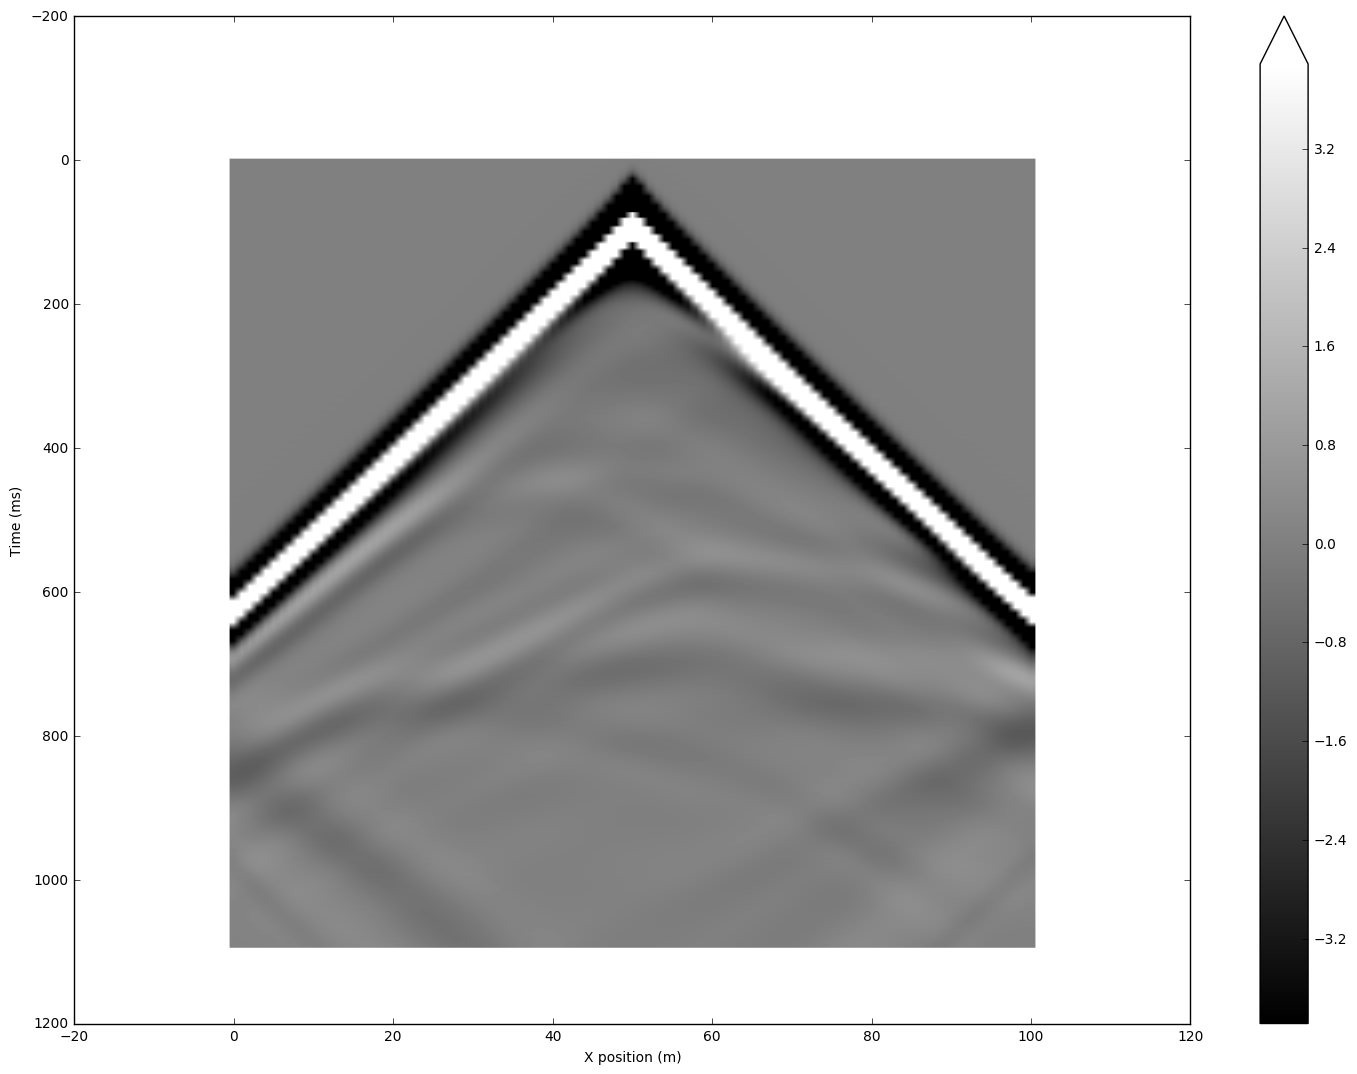

In [5]:
# %%snakeviz
data, rec, src = demo.get_shot(demo.nsrc/2)

# Create acoustic modelling kernel.
Acoustic = Acoustic_cg(model0, data, src, t_order=2, s_order=10)

# Execute acoustic forward model.
rec0, u, gflopss, oi, timings = Acoustic.Forward(save=False, dse='advanced')

demo.plot_record(rec0)

## RTM loop

# %%snakeviz
def grad_shot(i):
    demo = demo_toolkit.marmousi2D()

    model0 = demo.get_initial_model()
    data, rec, src = demo.get_shot(i)

    Acoustic0 = Acoustic_cg(model0, data, src, t_order=2, s_order=4)
    rec0, u0, gflopss, oi, timings = Acoustic0.Forward(save=True, dse='advanced')

    # Return gradient
    return Acoustic0.Gradient(rec0 - rec, u0, cache_blocking=None)

# grads = dview.map(grad_shot, range(8))
grads = map(grad_shot, range(8))

grad = sum(grads)

demo.plot_rtm(grad)
# print(grad)

## FWI

In [ ]:
import random
import scipy.optimize
import numpy.linalg
import os
os.environ["DEVITO_OPENMP"] = "1"

def get_alpha_i(args):
    vp = args[0]
    i = args[1]
    residule_0 = args[2]
    
    demo = demo_toolkit.small_marmousi2D()
    data_o, rec_o, src = demo.get_shot(i)

    model = IGrid(demo.origin, demo.spacing, vp)

    Acoustic = Acoustic_cg(model, data_o, src, t_order=2, s_order=4)
    rec, u, gflopss, oi, timings = Acoustic.Forward(save=True, dse='advanced')

    residule_1 = rec - rec_o
    
    diff = residule_0.flatten()-residule_1.flatten()
    alpha0 = residule_0.flatten().dot(diff)
    alpha1 = diff.dot(diff)
    
    return alpha0, alpha1

def get_alpha(x, shape, shots, residules):
    vp = x.reshape(shape)
    worklist = [(vp, ishot, iresidule) for ishot, iresidule in zip(shots, residules)]
    
    alpha0 = 0
    alpha1 = 0
    for alpha01 in dview.map(get_alpha_i, worklist):
    # for alpha01 in map(get_alpha_i, worklist):
        alpha0 += alpha01[0]
        alpha1 += alpha01[1]
    
    return alpha0/alpha1

def get_fg_i(args):
    vp = args[0]
    i = args[1]
    demo = demo_toolkit.small_marmousi2D()
    data_o, rec_o, src = demo.get_shot(i)

    model = IGrid(demo.origin, demo.spacing, vp)

    Acoustic = Acoustic_cg(model, data_o, src, t_order=2, s_order=4)
    rec, u, gflopss, oi, timings = Acoustic.Forward(save=True, dse='advanced')

    residule = rec - rec_o
    f = 0.5*numpy.linalg.norm(residule)**2

    # Calculate gradient, g
    g = Acoustic.Gradient(residule, u, cache_blocking=None)

    return f, g[40:-40, 40:-40].flatten(), residule

def get_fg(x, shape, shots):
    vp = x.reshape(shape)
    residules = []
    
    worklist = [(vp, i) for i in shots]
    f = 0
    g = None
    for fg in dview.map(get_fg_i, worklist):
        f += fg[0]
        if g is None:
            g = numpy.copy(fg[1])
        else:
            g += fg[1]
        residules.append(fg[2])
    
    return f, g, residules

In [ ]:
vp = numpy.copy(model0.vp)

print ("True residule 0: %g"%(numpy.linalg.norm(vp - model.vp)))

for i in range(10):
    shots = random.sample(range(demo.nsrc), 101)
    
    f, g, residules = get_fg(vp.flatten(), vp.shape, shots)
    
    # Mask out the water velocity
    g = numpy.where(vp.flatten()<1.501, 0, g)
    
    dm = 0.01*g.reshape(vp.shape)/numpy.abs(numpy.amax(g))
    
    vp_sigma = vp + dm

    # Get the step length.
    alpha = get_alpha(vp_sigma.flatten(), vp.shape, shots, residules)
    vp = vp + alpha*dm

    # Apply box constraints
    vp = numpy.where(vp<1.502, 1.502, vp)
    vp = numpy.where(vp>4.500, 4.500, vp)

    print ("Functional = %g (alpha=%g)"%(f, alpha))

print ("True residule: %g"%(numpy.linalg.norm(vp - model.vp)))

True residule 0: 15.4057
Functional = 4.32104e+07 (alpha=5.87252)


In [ ]:
demo.plot_velocity(vp)

In [ ]:
demo.plot_velocity(model0.vp)

In [ ]:
l = plt.imshow(numpy.transpose(model0.vp-vp), cmap=cm.seismic)
plt.colorbar(l, shrink=.25)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

l = plt.imshow(numpy.transpose(g.reshape(vp.shape)), cmap=cm.seismic)
plt.colorbar(l, shrink=.25)
plt.show()


In [ ]:
shots = random.sample(range(demo.nsrc), 4)
args=(vp.shape, shots)

result = scipy.optimize.minimize(get_fg, vp.flatten(), args=args,
                                 method='CG', jac=True,
                                 options={"maxiter": 2, "disp": True})
print (result)

In [ ]:
demo.plot_velocity(vp)

In [ ]:
shots = random.sample(range(demo.nsrc), 4)
args=(vp.shape, shots)
                                            
result = scipy.optimize.minimize(get_fg, vp.flatten(), args=args,
                                 method='BFGS', jac=get_g,
                                 options={"maxiter": 1, "disp": True})
print (result)

True residule 0: 37.8581
Functional = 911658 (alpha=1.45444)
Functional = 764962 (alpha=0.895654)
Functional = 719039 (alpha=0.53512)
Functional = 712353 (alpha=0.248339)
Functional = 713719 (alpha=0.0426593)
Functional = 714090 (alpha=0.00481287)